Instructions
- Choose an algorithm to run (REINFORCE, DQN)
- Choose environment to train on
- Define Neural network
- Run & Plot the right settings + network

## Initialization

In [0]:
%matplotlib inline
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm, tnrange, tqdm_notebook
import warnings

import random
import time
from collections import defaultdict

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

EPS = float(np.finfo(np.float32).eps)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## REINFORCE 

In [0]:
warnings.filterwarnings("ignore")

def select_action_REINFORCE(model, state):
    # Samples an action according to the probability distribution induced by the model
    # Also returns the log_probability
    # YOUR CODE HERE
    state = torch.tensor(state, dtype=torch.float)
    p = model(state)
    log_p = torch.nn.functional.log_softmax(p)
    action = torch.multinomial(log_p.exp(), 1).item()
    return action, log_p[action]

def run_episode(env, model):
    # YOUR CODE HERE
    s = env.reset()
    done = False
    episode = []
    while not done:
        a, log_p = select_action_REINFORCE(model, s)
        #print(s)
        s_next, r, done, _ = env.step(a)
        episode.append((r, log_p))
        s = s_next

    return episode

def compute_reinforce_loss(episode, discount_factor):
    # Compute the reinforce loss
    # Make sure that your function runs in LINEAR TIME
    # Don't forget to normalize your RETURNS (not rewards)
    # Note that the rewards/returns should be maximized 
    # while the loss should be minimized so you need a - somewhere
    
    # YOUR CODE HERE
    G_list = []
    log_p_list = []
    G = 0
    for r, log_p in reversed(episode):
        log_p_list.append(log_p)
        G = discount_factor * G + r
        G_list.append(G)
        
    log_p_vector = torch.stack(log_p_list)
    
    G_vector = torch.tensor(G_list, dtype=torch.float)
    mean = torch.mean(G_vector)
    std = torch.std(G_vector)
    G_norm = (G_vector - mean)/std
    
    loss = -log_p_vector @ G_norm
    return loss


def run_episodes_policy_gradient(model, env, num_episodes, discount_factor, learn_rate):
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    episode_durations = []
    for i in tqdm(range(num_episodes)):
        
        # YOUR CODE HERE
        episode = run_episode(env, model)
        loss = compute_reinforce_loss(episode, discount_factor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                           
#         if i % 10 == 0:
# #             print("{2} Episode {0} finished after {1} steps"
# #                   .format(i, len(episode), '\033[92m' if len(episode) >= 195 else '\033[99m'))
#             #print(len(episode))
        episode_durations.append(len(episode))
        
    return episode_durations

## ICM


In [0]:
class ICM(nn.Module):
    
    def __init__(self, len_state, num_actions, hidden_dims=[], lr=1e-3, curiosity_cap=2, curiosity_factor = 1):
        nn.Module.__init__(self)
        
        layers = []
        d_in = len_state + num_actions
        for hidden_dim in hidden_dims:
            d_out = hidden_dim
            layers.append(nn.Linear(d_in, d_out))
            layers.append(nn.ReLU())
            d_in = d_out
        d_out = len_state
        layers.append(nn.Linear(d_in, d_out))
        self.mlp = nn.Sequential(*layers).to(device)
        
        self.num_actions = num_actions
        
        self.curiosity_factor = curiosity_factor
        self.curiosity_cap = curiosity_cap
        
        self.optimizer = optim.SGD(self.mlp.parameters(), lr=lr)
        
    def compute_prediction_error(self, s, a, s_next, done):
        a_onehot = nn.functional.one_hot(a, self.num_actions)
        x = torch.cat([s.detach(), a_onehot.float().detach()], dim=1)
        #print(x)
        s_pred = self.mlp(x)
        #print(s_pred)
        delta_s = s_next.detach() - s_pred
        #print(delta_s)
        #print(delta_s**2)
        errors = (1-done.float().detach())*(delta_s**2).sum(dim=1)
        #print(errors)
        return errors
    
    def compute_intrinsic_rewards(self, s, a, s_next, done):
        errors = self.compute_prediction_error(s, a, s_next, done)
        return torch.clamp(self.curiosity_factor * errors.detach(), min=0, max=self.curiosity_cap)

    def update_params_and_compute_intrinsic_rewards(self, s, a, s_next, done):
        errors = self.compute_prediction_error(s, a, s_next, done)
        loss = errors.sum()
        # backpropagation of loss to Neural Network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return torch.clamp(self.curiosity_factor * errors.detach(), min=0, max=self.curiosity_cap)

aga = ICM(2,4)
print(aga.mlp.state_dict().items())
for i in range(1):
    aga.update_params_and_compute_intrinsic_rewards(torch.tensor([[2.,2.],[2.,2.]]).to(device), torch.tensor([1,3]).to(device), torch.tensor([[1.5,2.],[2.,2.5]]).to(device), torch.tensor([0.,0.]).to(device))
print(aga.mlp.state_dict().items())

odict_items([('0.weight', tensor([[-0.2811, -0.3111, -0.3589,  0.2639,  0.2381, -0.2489],
        [ 0.1600,  0.0821, -0.1738,  0.0140, -0.2463, -0.1195]])), ('0.bias', tensor([0.1614, 0.0577]))])
odict_items([('0.weight', tensor([[-0.2590, -0.2890, -0.3589,  0.2685,  0.2381, -0.2423],
        [ 0.1741,  0.0961, -0.1738,  0.0169, -0.2463, -0.1154]])), ('0.bias', tensor([0.1725, 0.0647]))])


## DQN

In [0]:
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.write_index = 0

    def push(self, transition):
        # YOUR CODE HERE
        if len(self.memory) < self.capacity:
            self.memory.append(transition)
        else:
            self.memory[self.write_index] = transition
            self.write_index += 1
            if self.write_index == self.capacity:
              self.write_index = 0


    def sample(self, batch_size):
        # YOUR CODE HERE
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def get_epsilon(it):
    # YOUR CODE HERE
    if it < 1000:
        return 1 - it/1000 * 0.95
    else:
        return 0.05

def select_action_DQN(model, state, epsilon):
    # YOUR CODE HERE  
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            state = torch.from_numpy(state).float().to(device)
            a = model(state)
            return torch.argmax(a).item()

def compute_q_val(model, state, action):
    # YOUR CODE HERE
    action_values = model(state)
    rows = [i for i in range(action_values.shape[0])]
    return action_values[rows, action]
    
def compute_target(model, reward, next_state, done, discount_factor, device):
    # done is a boolean (vector) that indicates if next_state is terminal (episode is done)
    # YOUR CODE HERE
    action_values = model(next_state)
    return reward + discount_factor * torch.max(action_values, 1).values * (1 - done.float())

def train(model, target_model, memory, optimizer, batch_size, discount_factor, device, ICM_model):
    # DO NOT MODIFY THIS FUNCTION
    mse = nn.MSELoss()
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)

    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float).to(device)
    action = torch.tensor(action, dtype=torch.int64).to(device)  # Need 64 bit to use them as index int64
    next_state = torch.tensor(next_state, dtype=torch.float).to(device)
    reward = torch.tensor(reward, dtype=torch.float).to(device)
    done = torch.tensor(done, dtype=torch.uint8).to(device)  # Boolean uint8


    if ICM_model:
        intrinsic_reward = ICM_model.update_params_and_compute_intrinsic_rewards(state, action, next_state, done)
        reward = reward + intrinsic_reward
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(target_model, reward, next_state, done, discount_factor, device)
    
    # loss is measured from error between current and newly expected Q values
#     loss = F.smooth_l1_loss(q_val, target)
    loss = mse(q_val, target)


    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item() # Returns a Python scalar, and releases history (similar to .detach())

def run_episodes(train, model, target_model, memory, env, num_episodes, batch_size, discount_factor, learn_rate, learn_rate_decay, device, ICM_model=None):
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  
    greedy_durations = []
    max_states = []
    steps_greedy = []
    intrinsic_rewards_tot = []
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, learn_rate_decay, last_epoch=-1)
    for i in tqdm_notebook(range(num_episodes)):
        target_model.load_state_dict(model.state_dict())
        s = env.reset()
        done = False
        steps = 0
        max_pos = -0.5
        intrinsic_rewards = 0
        while not done:
            epsilon = get_epsilon(global_steps)
            a = select_action_DQN(model, s, epsilon)
            s_next, r, done, _ = env.step(a)
            new_pos = s_next[0]
            if new_pos > max_pos:
              max_pos = new_pos
            
            state = torch.tensor(s, dtype=torch.float).to(device).unsqueeze(0)
            action = torch.tensor(a, dtype=torch.int64).to(device).unsqueeze(0) 
            next_state = torch.tensor(s_next, dtype=torch.float).to(device).unsqueeze(0)
            done = torch.tensor(done, dtype=torch.float).to(device).unsqueeze(0)


            intrinsic_reward = ICM_model.compute_intrinsic_rewards(state, action, next_state, done) if ICM_model else 0*done
            memory.push((s, a, r, s_next, done))
            # Update
            loss = train(model, target_model, memory, optimizer, batch_size, discount_factor, device, ICM_model)
            intrinsic_rewards = intrinsic_rewards + intrinsic_reward
            s = s_next
            global_steps = global_steps + 1  
            steps = steps + 1
        if i % 10 == 0:
          s = env.reset()
          done = False
          epsilon = 0
          step_greedy = 0
          while not done:
            a = select_action_DQN(model, s, epsilon)
            s_next, r, done, _ = env.step(a)
            s = s_next
            step_greedy = step_greedy + 1
        if (i+1) % 50 == 0:
          plot_q_values(model)
          plot_memory_and_curiosity(memory, ICM_model)
        intrinsic_rewards_tot.append(intrinsic_rewards)
        steps_greedy.append(step_greedy)
        episode_durations.append(steps)
        max_states.append(max_pos)
        scheduler.step()
        
    #env.close()    
    return episode_durations, max_states, steps_greedy, intrinsic_rewards_tot

## Choose environment

In [15]:
import gym
#env = gym.envs.make("CartPole-v0")
env = gym.envs.make("MountainCar-v0")
#env = gym.envs.make("Acrobot-v1")

print("number of actions: " + str(env.action_space.n))
print("number of observations: " + str(env.observation_space.shape[0]))

num_actions = env.action_space.n
len_state = env.observation_space.shape[0]

number of actions: 3
number of observations: 2


## Define network

In [0]:
class Network(nn.Module):
    
    def __init__(self, len_states, len_actions, hidden_dims):
        nn.Module.__init__(self)
        layers = []
        d_in = len_state
        for hidden_dim in hidden_dims:
            d_out = hidden_dim
            layers.append(nn.Linear(d_in, d_out))
            layers.append(nn.ReLU())
            d_in = d_out
        d_out = len_actions
        layers.append(nn.Linear(d_in, d_out))
        self.mlp = nn.Sequential(*layers).to(device)

    def forward(self, x):
        # YOUR CODE HERE
        return self.mlp(x)

## Plot visited states and intrinsic rewards

In [0]:
def plot_memory_and_curiosity(memory2, ICM_model):
    # random transition batch is taken from experience replay memory
    transitions = memory2.memory
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)

    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float).to(device)
    action = torch.tensor(action, dtype=torch.int64).to(device)  # Need 64 bit to use them as index int64
    next_state = torch.tensor(next_state, dtype=torch.float).to(device)
    reward = torch.tensor(reward, dtype=torch.float).to(device)
    done = torch.tensor(done, dtype=torch.uint8).to(device)  # Boolean uint8
    
    intrinsic_reward = ICM_model.compute_intrinsic_rewards(state, action, next_state, done) if ICM_model else 0*done

    x = state[:,0].tolist()
    y = state[:,1].tolist()
    colors = intrinsic_reward.tolist()
    area = ((0*10 * action+0.25*20).tolist())
    print( (action+1).tolist())
    #area = 100*(1 +0*np.random.rand(16))

    plt.figure()
    plt.title("States in memory with intrinsic reward")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.scatter(x, y, s=area, c=colors, alpha=0.5)
    plt.show()

def plot_q_values(model):
    x = np.arange(-1.2, 0.61, 0.01)
    y = np.arange(-0.06, 0.061, 0.001)
    X, Y = np.meshgrid(x, y)
    state = torch.from_numpy(np.stack((X, Y), axis=2))
    #print(X)
    #print(Y)
    #print(state)
    #Z = compute_q_val(model, state, action=torch.zeros(40000))
    with torch.no_grad():
      Z = model(state.float())
    #print(Z)

    from pylab import cm
    #for i in range(num_actions):
      #fig, ax = plt.subplots()
      #im = ax.imshow(Z[:,:,i],cmap=cm.RdBu)
      #CS = ax.contour(X, Y, Z[:,:,i])
      #ax.clabel(CS, inline=1, fontsize=10)
      #ax.set_title('Simplest default with labels')
    #fig, ax = plt.subplots()
    #im = ax.imshow(torch.max(Z, dim=2).values,cmap=cm.RdBu)
    plt.figure()
    plt.title("")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    CS = plt.contour(X, Y, torch.max(Z, dim=2).values)
    plt.clabel(CS, inline=1, fontsize=10)
    #fig, ax = plt.subplots()
    #im = ax.imshow(torch.argmax(Z, dim=2),cmap=cm.RdBu)
    #plt.figure()
    #plt.title("Action with maximum Q-value")
    #plt.xlabel("Position")
    #plt.ylabel("Velocity")
    #CS = plt.contour(X, Y, torch.argmax(Z, dim=2))
    #plt.clabel(CS, inline=1, fontsize=10)
    #fig, ax = plt.subplots()
    #im = ax.imshow(Z[:,:,0]-Z[:,:,2],cmap=cm.RdBu)
    plt.figure()
    plt.title("Difference between Q-values for \"left\" and \"right\"")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    CS = plt.contour(X, Y, Z[:,:,0]-Z[:,:,2])
    plt.clabel(CS, inline=1, fontsize=10)

#plot_q_values(model)
#plot_memory_and_curiosity(memory, ICM_model)


## Running & Plotting

[1, 2, 3, 3, 2, 1, 3, 1, 3, 3, 1, 2, 2, 1, 3, 2, 3, 1, 3, 2, 1, 3, 3, 3, 1, 1, 1, 2, 1, 1, 2, 3, 1, 3, 3, 1, 2, 3, 2, 3, 2, 2, 2, 1, 2, 1, 3, 2, 1, 3, 1, 1, 3, 1, 1, 3, 2, 1, 3, 1, 3, 2, 2, 2, 3, 3, 1, 2, 3, 1, 3, 3, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 3, 3, 3, 1, 2, 2, 3, 1, 3, 3, 2, 3, 3, 3, 1, 3, 1, 3, 2, 2, 3, 2, 3, 1, 3, 2, 1, 2, 2, 2, 1, 3, 2, 1, 3, 1, 1, 1, 1, 2, 1, 3, 1, 1, 2, 3, 2, 3, 2, 3, 3, 1, 1, 1, 1, 3, 3, 2, 3, 3, 2, 3, 2, 1, 3, 1, 2, 1, 3, 2, 2, 1, 1, 2, 1, 1, 3, 3, 2, 2, 2, 2, 2, 2, 1, 3, 3, 1, 2, 1, 2, 3, 3, 2, 2, 1, 3, 2, 1, 2, 1, 2, 3, 3, 3, 1, 3, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 3, 2, 1, 2, 3, 3, 1, 3, 1, 2, 1, 2, 1, 1, 3, 3, 2, 2, 3, 2, 2, 3, 2, 1, 1, 1, 3, 1, 2, 1, 2, 3, 2, 1, 1, 3, 3, 3, 1, 3, 3, 3, 2, 1, 3, 2, 3, 3, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 2, 3, 3, 2, 2, 1, 1, 2, 2, 1, 2, 3, 2, 2, 1, 2, 1, 1, 2, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 2, 2, 3, 3, 2, 1, 3, 2, 3, 3, 3, 3, 3, 2, 3, 1, 3, 1, 3, 3, 2, 3, 1, 1, 1, 2, 1, 3, 2, 1, 2, 3, 2, 3, 2, 2, 1, 2, 2, 1, 1, 

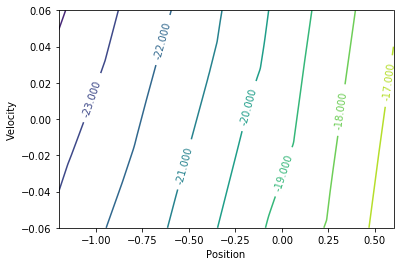

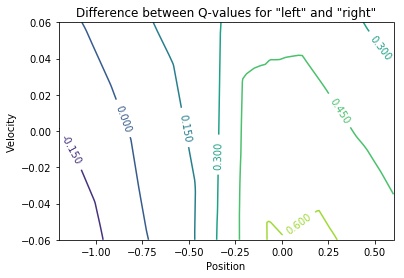

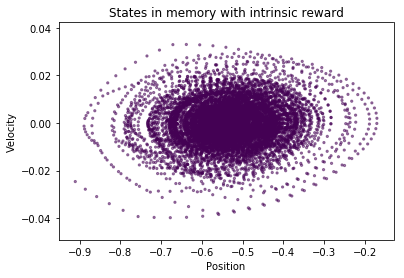

[2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

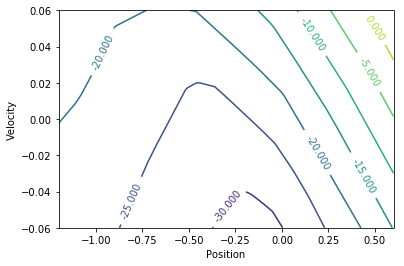

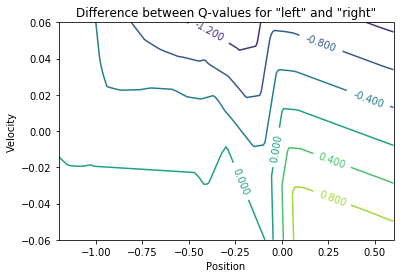

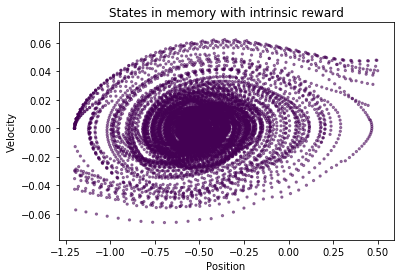

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

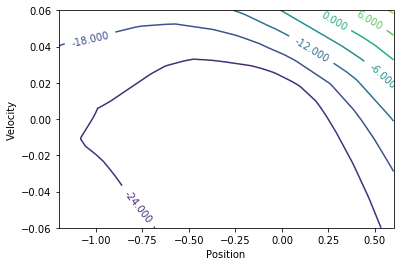

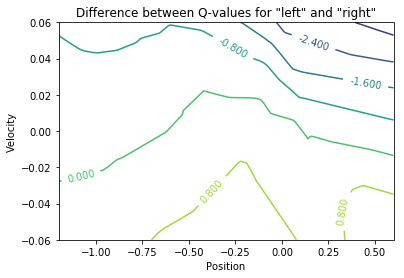

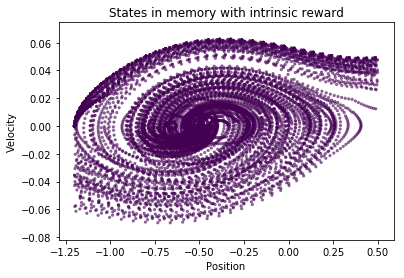

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 

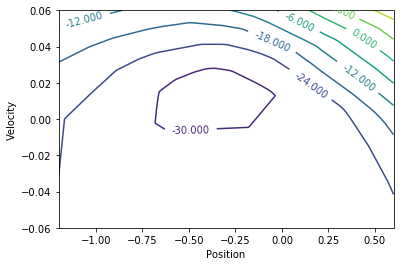

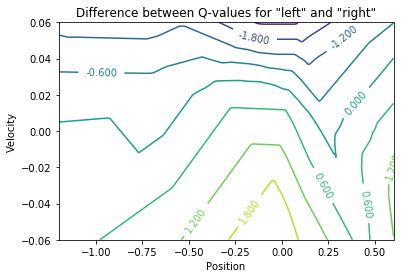

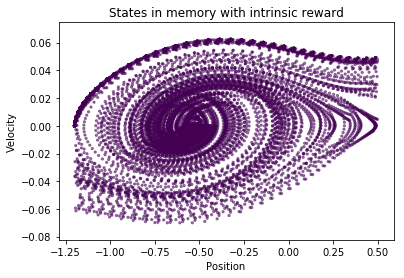

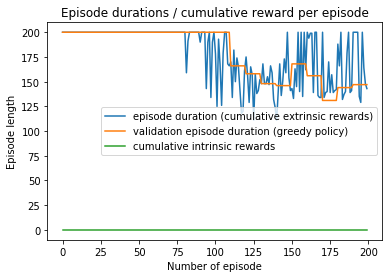

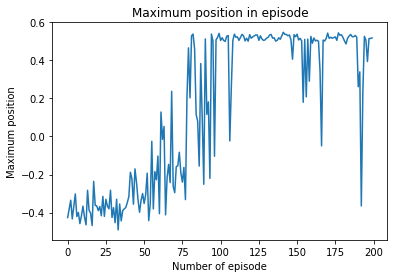

In [30]:
# Settings policy gradient
# num_episodes = 200
# num_hidden = 128
# discount_factor = 0.99
# learn_rate = 0.01

# Settings DQN
num_episodes = 200
batch_size = 64
discount_factor = 0.97
learn_rate = 1e-2
learn_rate_final = 1e-3
learn_rate_decay = (learn_rate_final/learn_rate)**(1/num_episodes)
memory1 = ReplayMemory(10000)
hidden_dims = [128]

seed = 42
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

model = Network(len_state, num_actions, hidden_dims).to(device)
target_model = Network(len_state, num_actions, hidden_dims).to(device)
target_model.load_state_dict(model.state_dict())
use_ICM = False
ICM_model = ICM(len_state, num_actions, hidden_dims=[128], curiosity_factor = 500, curiosity_cap = 1) if use_ICM else None

# Policy gradient method
# episode_durations = run_episodes_policy_gradient(model, env, num_episodes, discount_factor, learn_rate)

# DQN
episode_durations, max_states, steps_greedy, intrinsic_rewards_tot = run_episodes(train, model, target_model, memory1, env, num_episodes, batch_size, discount_factor, learn_rate, learn_rate_decay, device, ICM_model)

plt.plot(episode_durations)
plt.plot(steps_greedy)
plt.plot(intrinsic_rewards_tot)
plt.title('Episode durations / cumulative reward per episode')
plt.legend(['episode duration (cumulative extrinsic rewards)', "validation episode duration (greedy policy)", "cumulative intrinsic rewards"])
plt.xlabel("Number of episode")
plt.ylabel("Episode length");
plt.show()
plt.plot(max_states);
plt.title("Maximum position in episode")
plt.xlabel("Number of episode")
plt.ylabel("Maximum position")
plt.show()

## Random search

In [19]:
# Standard settings
num_episodes = 200
batch_size = 64
# seed = 42
# random.seed(seed)
# torch.manual_seed(seed)
# env.seed(seed)
memory = ReplayMemory(10000)

# Specify the list of parameters to pick from
problem = "mc" # Mountain car, Acrobot is "ab"
# list_hidden_dims = [[128], [64, 32], [128, 16], [16,64,16], [8, 16, 64, 16, 8]]
# list_discount_factor = [0.8, 0.85, 0.9, 0.95, 0.97,0,98, 0.99]
# list_learning_rate = [1e-1, 1e-2, 1e-3]
# list_learning_rate_final_factor = [1e-1, 1e-2, 1e-3]

# list_curiosity_factor = [1, 5, 10, 25, 50, 100, 250, 500]
# list_curiosity_cap = [1, 10]
# list_ICM_layers = [[], [128], [128, 16]]

# Put one factor everywhere
list_hidden_dims = [[128]]
list_discount_factor = [0.95]
list_learning_rate = [1e-2]
list_learning_rate_final_factor = [1e-1]

list_curiosity_factor = [50]
list_curiosity_cap = [1]
list_ICM_layers = [[128]]

use_ICM = True

num_iterations = 1

def random_grid_search(list_hidden_dims, list_discount_factor, list_learning_rate, list_learning_rate_final_factor, 
                       list_curiosity_factor, list_curiosity_cap, list_ICM_layers, use_ICM, problem, num_iterations):
  # Random grid search, where each run a plot is saved so you can analyze afterwards
  list_episode_durations = []
  list_max_states = []
  list_steps_greedy = []
  list_intrinsic_rewards_tot = []

  for i in range(num_iterations):
    hidden_dims = random.choice(list_hidden_dims)
    discount_factor = random.choice(list_discount_factor)
    learn_rate = random.choice(list_learning_rate)
    learn_rate_final = learn_rate*random.choice(list_learning_rate_final_factor)
    learn_rate_decay = (learn_rate_final/learn_rate)**(1/num_episodes)

    curiosity_factor = random.choice(list_curiosity_factor)
    curiosity_cap = random.choice(list_curiosity_cap)
    ICM_layers = random.choice(list_ICM_layers)

    # Important tunable variables: num_hidden, discount_factor, (learn_rate)
    model = Network(len_state, num_actions, hidden_dims).to(device)
    target_model = Network(len_state, num_actions, hidden_dims).to(device)
    target_model.load_state_dict(model.state_dict())
    ICM_model = ICM(len_state, num_actions, hidden_dims=ICM_layers, curiosity_factor=curiosity_factor, curiosity_cap=curiosity_cap) if use_ICM else None
    episode_durations, max_states, steps_greedy, intrinsic_rewards_tot = run_episodes(train, model, target_model, memory, env, num_episodes, batch_size, discount_factor, learn_rate, learn_rate_decay, device, ICM_model)

    list_episode_durations.append(episode_durations)
    list_max_states.append(max_states)
    list_steps_greedy.append(steps_greedy)
    list_intrinsic_rewards_tot.append(intrinsic_rewards_tot)

    plt.plot(episode_durations)
    plt.plot(steps_greedy)
    plt.plot(intrinsic_rewards_tot)
    plt.title(f"DQN d l l_f c_f c_c, ICM:{hidden_dims}, {discount_factor}, {learn_rate}, {learn_rate_final}, {curiosity_factor}, {curiosity_cap}, {ICM_layers}")
    plt.legend(['episode duration', "steps_greedy", "intrinsic rewards"])
    plt.xlabel("Number of episode")
    plt.ylabel("Episode length");
    plt.savefig(f"plot {problem}, {hidden_dims}, {discount_factor}, {learn_rate}.png")
    plt.show()
    plt.plot(max_states)
    plt.title("Maximum of states")
    plt.xlabel("Number of episode")
    plt.ylabel("Position")
    plt.show()

    return list_episode_durations, list_max_states, list_steps_greedy, list_intrinsic_rewards_tot

list_episode_durations, list_max_states, list_steps_greedy, list_intrinsic_rewards_tot = random_grid_search(list_hidden_dims, list_discount_factor, list_learning_rate, list_learning_rate_final_factor, list_curiosity_factor, list_curiosity_cap, 
                   list_ICM_layers, use_ICM, problem, num_iterations)


pickle.dump(list_episode_durations, open( "list_episode.p", "wb" ) )
pickle.dump(list_max_states, open( "list_max_states.p", "wb" ) )
pickle.dump(list_steps_greedy, open( "list_steps_greedy.p", "wb" ) )
pickle.dump(list_intrinsic_rewards_tot, open( "list_intrinsic_rewards.p", "wb" ) )

KeyboardInterrupt: ignored